In [1]:
import networkx as nx
import torch
from torch_geometric.data import Data
import torch_geometric
import numpy as np
from torch_geometric.datasets import CoraFull, CitationFull
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import seaborn as sns

from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.transforms import ToUndirected
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric.transforms import ToUndirected
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal


%config InlineBackend.figure_format = 'retina'
sns.set()


In [2]:
ADJ_PATH = '/home/udit/Documents/Progyan/results_new_95/Year_{}.npy'
COORD_PATH = '/home/udit/Documents/Progyan/Lat_lon/lat_lon-{}.csv'

In [5]:
graph_list = []

for year in tqdm(range(2003, 2016)):
    if year == 2005 or year == 2012:
        continue
    i = year
    adj_matrix = np.load(ADJ_PATH.format(i))
    lat_lon_df = pd.read_csv(COORD_PATH.format(i))

    adj_matrix = adj_matrix + adj_matrix.transpose()
    ##### REMOVE ######
    adj_matrix = adj_matrix[:4523, :4523]
    ###################
    adj_matrix[adj_matrix  < 0.7] = 0
    np.fill_diagonal(adj_matrix, 0)
    G = nx.from_numpy_matrix(adj_matrix)

    lat_lon_dict = {}
    for i in range(len(lat_lon_df)):
        lat_lon_dict[i] = [lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat'], lat_lon_df.loc[i, 'rain']]

    nx.set_node_attributes(G, lat_lon_dict, 'pos')
    pos = nx.get_node_attributes(G, 'pos')

    central_nodes = []

    for n in G.nodes:
        if G.nodes[n]['pos'][0] > 67 and G.nodes[n]['pos'][0] < 97 and G.nodes[n]['pos'][1] > 5.5 and G.nodes[n]['pos'][1] < 38:
            central_nodes.append(n)

    G = G.subgraph(central_nodes)

    graph_list.append(G)

100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


0it [00:00, ?it/s]/tmp/ipykernel_65203/793534699.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')
/tmp/ipykernel_65203/793534699.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_edge = plt.cm.get_cmap('tab20')
0it [00:00, ?it/s]


ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (2, 3).

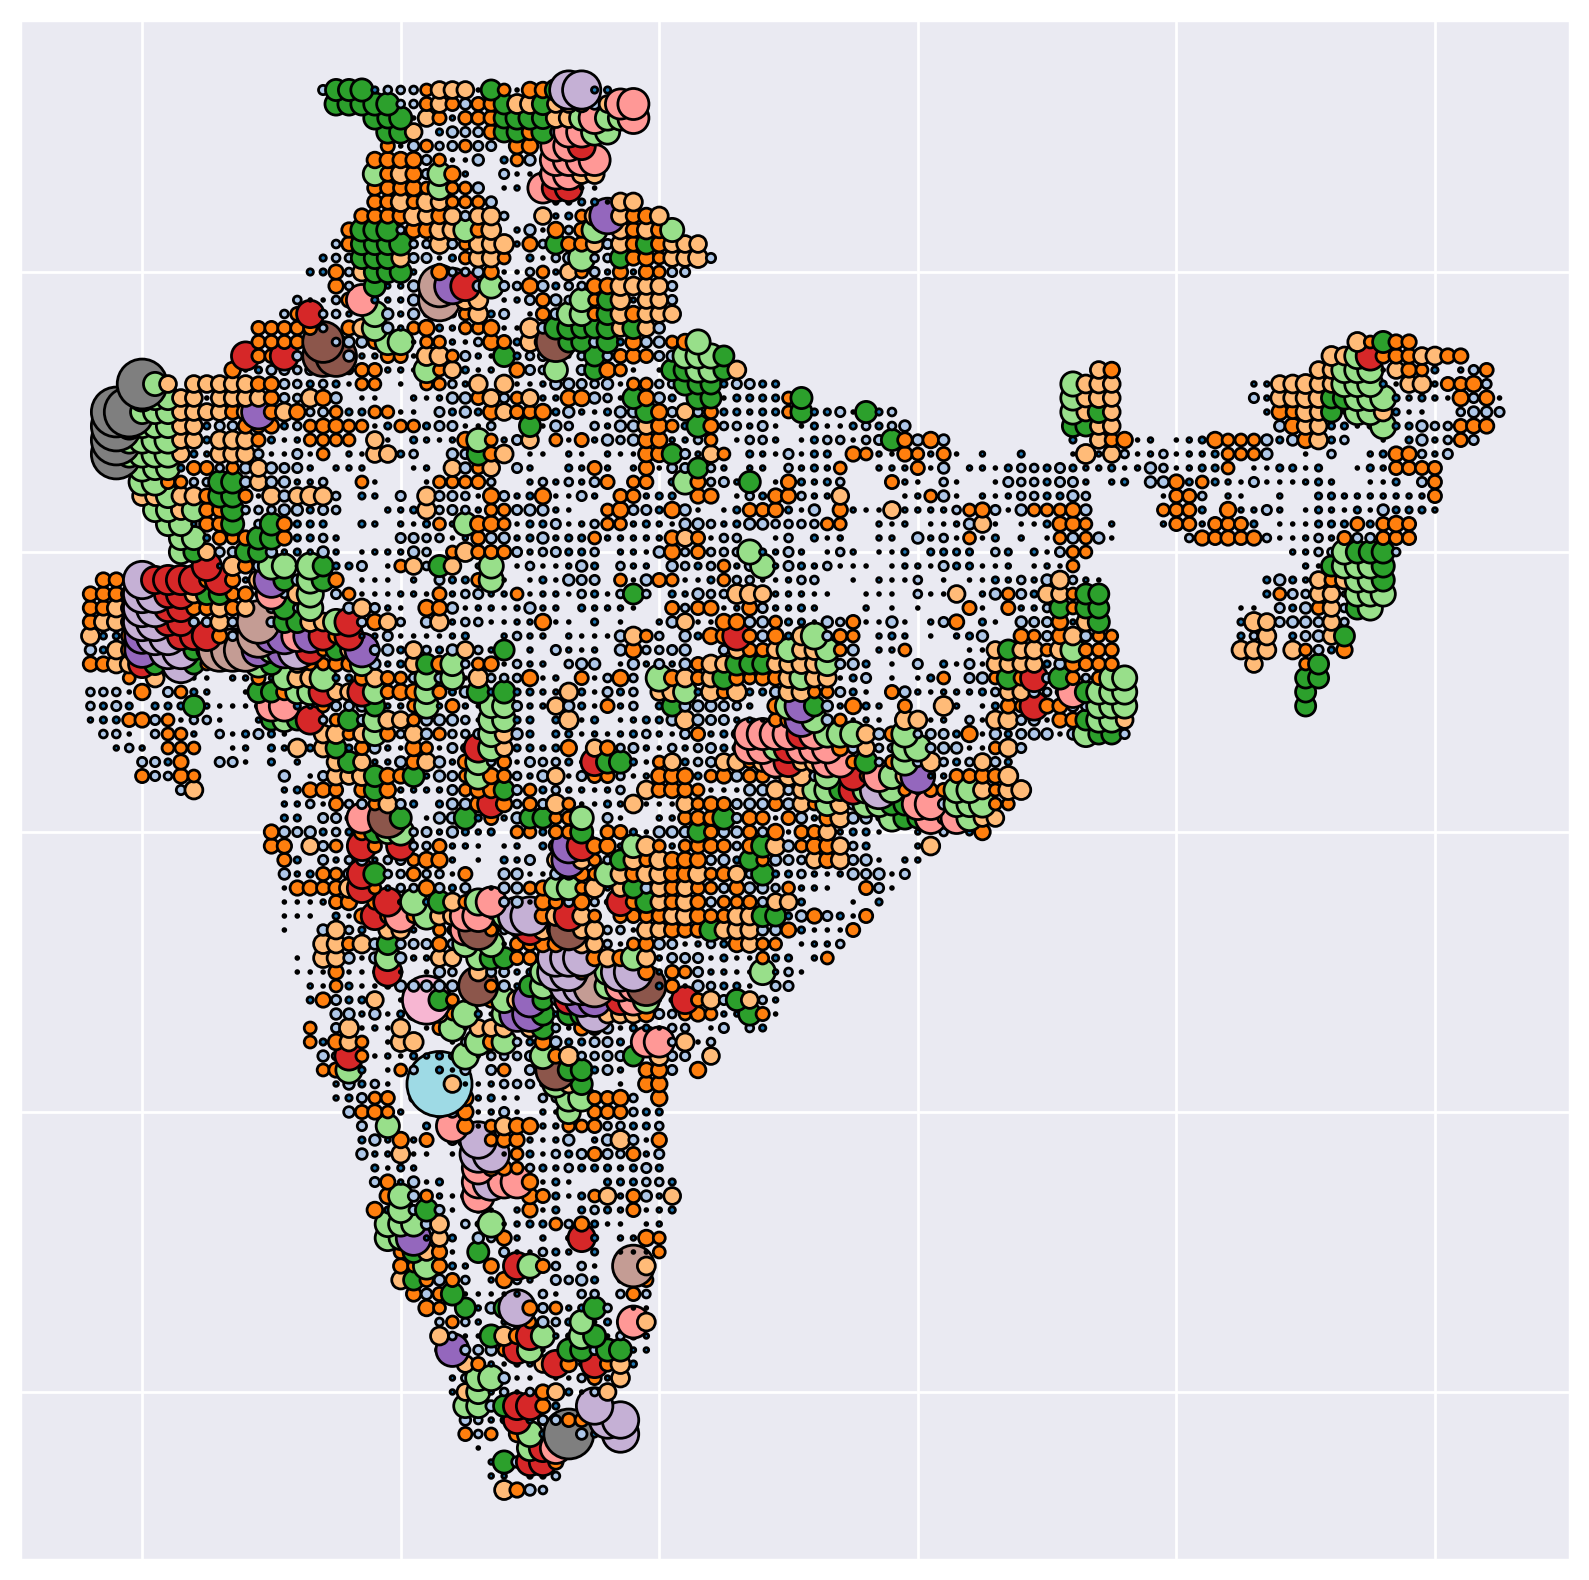

In [195]:
for _, G in tqdm(enumerate(graph_list)):        
    plot = plt.figure(figsize=(10,10))
    india_coords = [[67, 97], [5.5, 38]]
    india_pos = {}

    for node_id, coords in pos.items():
        if coords[1] > 5.5 and coords[1] < 38 and coords[0] > 67 and coords[0] < 97:
            india_pos[node_id] = coords

    d = dict(G.degree)
    degree_dict = dict(G.degree()) 
    degree_values = np.array(list(degree_dict.values())) 

    cmap = plt.cm.get_cmap('tab20')
    cmap_edge = plt.cm.get_cmap('tab20')

    normalized_degrees = (degree_values - degree_values.min()) / (degree_values.max() - degree_values.min())

    node_colors = cmap(normalized_degrees)

    edge_widths = [d['weight'] for (u, v, d) in G.edges(data=True)]
    edge_colors = [d['weight']**3 for (u, v, d) in G.edges(data=True)]

    edge_colors = cmap_edge(edge_colors)

    ################ PLOT NETWORK #####################
    nx.draw_networkx(G, pos = india_pos,
            nodelist=d, 
            width=edge_widths,
            edge_color=edge_colors,
            edgecolors = 'black',
            node_size=[(d[k])**1.5 for k in d],
            with_labels = False,
            node_color=node_colors,)
            
    img = plt.imread('/home/udit/Documents/Progyan/GNN/physical-map-india.jpg')
    plt.imshow(img, extent=[68, 96.5, 5.5, 36.5], alpha=1)
    plt.show()
    #####################################################

    save = plt.savefig(f'./temporal_train_graphs/graph{_}.png')

In [ ]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [ ]:
device = "cuda:2"

In [ ]:
lat_lon_df

,lat,lon,rain
0,8.25,77.00,36.417313
1,8.25,77.25,44.796236
2,8.25,77.50,68.980484
3,8.25,77.75,61.552216
4,8.50,76.75,45.694534
...,...,...,...
4863,37.00,75.50,32.251194
4864,37.25,74.50,16.869051
4865,37.25,74.75,18.297864
4866,37.25,75.00,22.074139


In [ ]:
node_features = []
for node in central_nodes:
    node_features.append(india_pos[node])

In [ ]:
len(G.edges)

341

In [ ]:
torch.tensor(list(nx.get_node_attributes(G, "pos").values()))[:, 2]

tensor([26.6749, 22.5548, 32.3383, 29.6935, 59.7692, 39.3874, 42.5243, 27.0444,
        39.0803, 29.7972, 47.3017, 21.4381, 30.9669, 26.8621, 24.3593, 32.0761,
        38.5803, 36.2012, 27.1280, 44.6846, 57.5413, 57.1000, 19.9116, 30.9225,
        30.4552, 29.4356, 19.4659, 36.7378, 23.5214, 23.5133, 41.0919, 45.5000,
        48.5903, 30.2262, 21.5203, 42.8273, 22.5530, 26.8519, 37.7343, 30.1513,
        36.2596, 40.5791, 35.7381, 39.8237, 28.5264, 33.7407, 27.0354, 20.1269,
        24.3601, 41.3420, 35.2050, 36.0032, 61.2496, 31.0248, 31.4872, 33.8130,
        34.4433, 36.8128, 36.6802, 24.3343, 24.2722, 31.3520, 29.4973, 27.5850,
        28.8157, 31.9643, 43.2170, 34.7887, 34.6455, 32.6334, 31.9821, 31.0304,
        38.5497, 54.3829, 48.5474, 30.1581, 54.4829, 30.5408, 38.5135, 54.2225,
        38.5770, 34.1685, 49.5303, 38.3610, 42.0016, 63.8223, 65.2398, 36.5424,
        25.5835, 33.9185, 38.0308, 33.8573, 43.7502, 32.1385, 43.6066, 37.7950,
        29.2555, 30.8733, 33.2168, 37.41

# DATASET GENERATION

In [ ]:
lat_lon_df = lat_lon_df.iloc[central_nodes]

list_node_features = []
list_edge_list = []
list_target_features = []
list_edge_weights = []

list_node_features_cpu = []
list_edge_list_cpu = []
list_target_features_cpu = []
list_edge_weights_cpu = []

j = 0

for i, graph in tqdm(enumerate(graph_list[:-1])):
    
    j = 2003 + i 
    if j == 2005 or j == 2012:
        j += 1

    adj_matrix = nx.to_numpy_matrix(graph)
    lat_lon_df = pd.read_csv(COORD_PATH.format(j))

    node_features = []
    target_features = []
    # for i in lat_lon_df.index:
    #     node_features.append([lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat'], lat_lon_df.loc[i, 'rain']])
    #     target_features.append([lat_lon_df.loc[i, 'rain']])
    # node_features = torch.tensor(node_features, dtype=torch.float)
    node_features = torch.tensor(list(nx.get_node_attributes(graph, "pos").values()))


    edge_list = set()
    edge_weights = []
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if adj_matrix[i, j] > 0:
                append_edge = frozenset({i, j})
                edge_list.add(append_edge)
    append_edge = frozenset({1, 2})
    edge_list.add(append_edge)
    edge_list = [tuple(x) for x in list(edge_list)]


    for x,y in edge_list:
        edge_weights.append(adj_matrix[x, y])

    edge_list = np.array(edge_list)
    edge_weights = np.array(edge_weights)
    edge_list = edge_list.transpose()

    central_pos = {}
    for _, i in enumerate(central_nodes):
        central_pos[_] = pos[i]

    transform = ToUndirected()

    list_node_features_cpu.append(np.array(node_features))
    list_edge_list_cpu.append(edge_list)
    list_target_features_cpu.append(np.array(node_features[:, 2]))
    list_edge_weights_cpu.append(edge_weights)

    # list_node_features.append((node_features).to(device))
    # list_edge_list.append((torch.from_numpy(edge_list)).to(device))
    # list_target_features.append(node_features[:, 2].to(device))
    # list_edge_weights.append(torch.tensor(edge_weights).to(device))

node_features_batch = (list_node_features)
edge_list_batch = (list_edge_list)
target_features_batch = (list_target_features)
edge_weights_batch = (list_edge_weights)

node_features_batch_cpu = list_node_features_cpu
edge_list_batch_cpu = list_edge_list_cpu
target_features_batch_cpu = list_target_features_cpu
edge_weights_batch_cpu = list_edge_weights_cpu




12it [00:00, 13.32it/s]


In [ ]:
print(target_features_batch_cpu)

[array([ 6.10417342, 14.01132202, 26.95849514,  5.53792739, 10.04167223,
        6.55781388,  6.18481994, 35.62147713, 18.87494755, 16.61920595,
       28.52497196, 11.16793919, 15.89241552,  3.86861312, 19.64578056,
       11.34844589, 22.27966404, 20.07697105, 11.23726606, 25.56426144,
        3.78009796, 15.17610979, 12.89781952, 16.23918867,  5.10005355,
        4.10442924,  8.5942378 , 11.64421654,  2.89046788,  2.06578678,
        8.71397543,  3.87194586,  4.31361699, 40.89999962, 11.05770874,
        6.98386049, 13.82227659, 20.2037344 ,  1.04483366, 20.03953838,
       26.30065727, 14.43018293,  3.80781484,  2.35789895, 11.48709774,
       16.96469784, 15.05939436, 24.33722019, 12.73587227, 30.69264603,
       15.54309416, 16.15478516,  4.28757429,  1.89998424,  0.9812316 ,
       20.11623764, 44.72255135, 21.55315781, 27.52567291, 10.68509722,
       36.37081242, 15.23756838, 16.70217609,  6.86899471, 11.51119661,
        6.26529026, 24.67264366, 11.47860193, 23.77641392,  9.1

In [ ]:
# np.roll(target_features_batch_cpu, 1)
target_features_batch_cpu = np.roll(target_features_batch_cpu, -1, axis = 0)
# target_features_batch = target_features_batch[1:].append(target_features_batch[0])

In [ ]:
target_features_batch = torch.from_numpy(target_features_batch_cpu)

In [ ]:
# dataset = DynamicGraphTemporalSignal(edge_indices= edge_list_batch, edge_weights=edge_weights_batch, features=node_features_batch, targets=target_features_batch)

dataset_cpu = DynamicGraphTemporalSignal(edge_indices= edge_list_batch_cpu, edge_weights=edge_weights_batch_cpu, features=node_features_batch_cpu, targets=target_features_batch_cpu)

In [ ]:
edge_list_batch_cpu[0].shape

(2, 238)

In [ ]:
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_count, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.recurrent2 = EvolveGCNH(node_count, dim_in)
        # self.bn1 = torch.nn.BatchNorm1d(dim_in)
        # self.bn2 = torch.nn.BatchNorm1d(dim_in)
        self.dropout = torch.nn.Dropout(0.4).to(device)

        self.linear = torch.nn.Linear(dim_in, 2)
        self.linear_2 = torch.nn.Linear(2, 1)
    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        # h = self.bn(h)
        h = self.recurrent2(h, edge_index, edge_weight).relu()
        h = self.dropout(h)
        # h = self.recurrent2(h, edge_index, edge_weight).relu()
        h = self.linear(h)
        h = self.linear_2(h)
        return h

In [ ]:
from torch_geometric.nn.conv import GATv2Conv

class Roland(torch.nn.Module):
    def __init__(self, num_layers, hidden, num_nodes) -> None:
        super().__init__()
        self.num_layers = num_layers
        self.hidden = hidden
        self.num_nodes = num_nodes
        self.conv = torch.nn.ModuleList()
        self.gru = torch.nn.ModuleList()
        self.h_0 = torch.nn.ParameterList()
        self.dropout = torch.nn.Dropout(0.4).to(device)


        self.conv.append(torch.nn.Sequential(
            GATv2Conv(-1, hidden), torch.nn.ReLU()))
        
        for i in range(num_layers - 1):
            self.conv.append(torch.nn.Sequential(
                GATv2Conv(hidden, hidden), torch.nn.ReLU()))
            self.gru.append(torch.nn.GRU(hidden, hidden))
            self.h_0.append(torch.nn.Parameter(torch.randn(1, hidden)))

        self.lin = torch.nn.Linear(hidden, hidden)
        self.lin_mid = torch.nn.Linear(hidden, hidden)
        self.lin2 = torch.nn.Linear(hidden, 1)


    def reset_parameters(self):

        for i in range(self.num_layers):
            self.conv[i].reset_parameters()
            if i != 0:
                self.gru[i-1].reset_parameters()
                self.h_0[i-1].reset_parameters()

        self.lin.reset_parameters()
        self.lin_mid.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x,edge_index):

        for i in range(self.num_layers):
            x = self.conv[i][0](x, edge_index)
            x = self.conv[i][1](x)

            if i != 0:
                x, self.h_0[i-1] = self.gru[i-1](x, self.h_0[i-1])
            
        x = self.lin(x)
        x = F.tanh(x)
        x = self.lin2(x)
        return x

In [ ]:

class Roland(torch.nn.Module):
    def __init__(self, num_layers, hidden, num_nodes) -> None:
        super().__init__()
        self.num_layers = num_layers
        self.hidden = hidden
        self.num_nodes = num_nodes
        self.conv = torch.nn.ModuleList()
        self.gru = torch.nn.ModuleList()
        self.h_0 = torch.nn.ParameterList()
        self.w_a = torch.nn.ParameterList()
        self.w_m = torch.nn.ParameterList()
        self.dropout = torch.nn.Dropout(0.4).to(device)


        self.conv.append(torch.nn.Sequential(
            GATv2Conv(-1, hidden), torch.nn.ReLU()))
        self.w_a.append(torch.nn.Parameter(torch.randn(num_nodes, hidden)))
        self.w_m.append(torch.nn.Parameter(torch.randn(hidden, hidden)))
        for i in range(num_layers - 1):
            self.conv.append(torch.nn.Sequential(
                GATv2Conv(hidden, hidden), torch.nn.ReLU()))
            self.gru.append(torch.nn.GRU(hidden, hidden))
            self.h_0.append(torch.nn.Parameter(torch.randn(1, hidden)))
            self.w_m.append(torch.nn.Parameter(torch.randn(hidden, hidden)))
            self.w_a.append(torch.nn.Parameter(torch.randn(num_nodes, hidden)))

        self.lin = torch.nn.Linear(hidden, hidden)
        self.lin_mid = torch.nn.Linear(hidden, hidden)
        self.lin2 = torch.nn.Linear(hidden, 1)


    def reset_parameters(self):

        for i in range(self.num_layers):
            self.conv[i].reset_parameters()
            self.w_a[i].reset_parameters()
            self.w_m[i].reset_parameters()
            if i != 0:
                self.gru[i-1].reset_parameters()
                self.h_0[i-1].reset_parameters()
        

        self.lin.reset_parameters()
        self.lin_mid.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x,edge_index):

        for i in range(self.num_layers):
            x = self.conv[i][0](x, edge_index)
            x = self.conv[i][1](x)
            x = torch.add(x, self.w_a[i])
            x = torch.matmul(x, self.w_m[i])
            x = F.relu(x)

            if i != 0:
                x, self.h_0[i-1] = self.gru[i-1](x, self.h_0[i-1])
            
        x = self.lin(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

In [ ]:
snapshot

Data(x=[209, 3], edge_index=[2, 238], edge_attr=[238], y=[209])

In [ ]:
# model = TemporalGNN(dataset_cpu[0].x.shape[0], dataset_cpu[0].x.shape[1])
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# model.train()
model = Roland(num_layers = 3, hidden = 32, num_nodes = dataset_cpu[0].x.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

Roland(
  (conv): ModuleList(
    (0): Sequential(
      (0): GATv2Conv(-1, 32, heads=1)
      (1): ReLU()
    )
    (1-2): 2 x Sequential(
      (0): GATv2Conv(32, 32, heads=1)
      (1): ReLU()
    )
  )
  (gru): ModuleList(
    (0-1): 2 x GRU(32, 32)
  )
  (h_0): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x32]
      (1): Parameter containing: [torch.float32 of size 1x32]
  )
  (w_a): ParameterList(
      (0): Parameter containing: [torch.float32 of size 209x32]
      (1): Parameter containing: [torch.float32 of size 209x32]
      (2): Parameter containing: [torch.float32 of size 209x32]
  )
  (w_m): ParameterList(
      (0): Parameter containing: [torch.float32 of size 32x32]
      (1): Parameter containing: [torch.float32 of size 32x32]
      (2): Parameter containing: [torch.float32 of size 32x32]
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (lin): Linear(in_features=32, out_features=32, bias=True)
  (lin_mid): Linear(in_features=32, out_features=3

In [ ]:
train_dataset, test_dataset = temporal_signal_split(dataset_cpu, train_ratio=0.4)

In [ ]:
for i, snapshot in enumerate(train_dataset):
    pass

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_dataset.targets.reshape(-1, 1))
targets_scaled = []
for _ in train_dataset.targets:
    targets_scaled.append(scaler.transform(_.reshape(-1,1)).reshape(-1,))


In [ ]:
train_dataset.targets = np.array(targets_scaled)

In [ ]:
test_scaled = []
for _ in test_dataset.targets:
    test_scaled.append(scaler.transform(_.reshape(-1,1)).reshape(-1,))

In [ ]:
test_dataset.targets = np.array(test_scaled)

In [ ]:
model = model.to("cuda:0")

In [ ]:
model.train()

Roland(
  (conv): ModuleList(
    (0): Sequential(
      (0): GATv2Conv(-1, 32, heads=1)
      (1): ReLU()
    )
    (1-2): 2 x Sequential(
      (0): GATv2Conv(32, 32, heads=1)
      (1): ReLU()
    )
  )
  (gru): ModuleList(
    (0-1): 2 x GRU(32, 32)
  )
  (h_0): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x32 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 1x32 (GPU 0)]
  )
  (w_a): ParameterList(
      (0): Parameter containing: [torch.float32 of size 209x32 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 209x32 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 209x32 (GPU 0)]
  )
  (w_m): ParameterList(
      (0): Parameter containing: [torch.float32 of size 32x32 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 32x32 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 32x32 (GPU 0)]
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (lin): Linear(in_features=32, out_features=3

In [ ]:
optimizer.lr = 5e-4

In [ ]:
import torch.nn as nn
criterion = nn.MSELoss()

In [ ]:
print(train_dataset[0].edge_attr)
train_dataset[0].edge_attr.max()
# print(train_dataset[1])

tensor([0.7070, 1.0000, 1.0000, 0.7070, 0.7070, 0.8160, 0.7070, 1.0000, 0.7070,
        0.8660, 0.8660, 1.0000, 0.8660, 0.7070, 1.0000, 0.7070, 0.7070, 1.0000,
        0.7070, 0.8160, 0.7070, 0.7500, 0.7070, 0.7070, 0.7070, 1.0000, 0.8160,
        0.8160, 0.7070, 1.0000, 0.8660, 0.7070, 0.7070, 0.8660, 0.7070, 0.8160,
        1.0000, 1.0000, 0.8160, 0.7500, 0.7070, 0.7500, 0.8160, 1.0000, 0.7070,
        0.7070, 0.7070, 0.7070, 0.7070, 0.7070, 0.7070, 0.7500, 0.7070, 0.7070,
        0.7070, 0.7070, 1.0000, 0.7070, 0.7070, 1.0000, 0.8160, 0.8160, 0.8660,
        0.8160, 0.7070, 1.0000, 0.7500, 1.0000, 0.7070, 0.7070, 0.7070, 0.7500,
        0.7070, 0.7070, 1.0000, 1.0000, 0.7070, 0.7070, 0.7070, 0.8660, 1.0000,
        0.7070, 1.0000, 0.7070, 1.0000, 0.8160, 0.8660, 0.8160, 0.7070, 0.7070,
        0.7070, 0.7070, 0.8160, 0.7070, 0.8160, 0.8160, 0.8660, 0.7070, 0.8160,
        1.0000, 1.0000, 0.8660, 0.8660, 0.8660, 0.8160, 0.8160, 0.7070, 0.8160,
        1.0000, 0.8160, 0.7070, 0.8160, 

tensor(1.)

In [ ]:
device

'cuda:2'

In [ ]:
model = model.to(device)

In [ ]:
# model.train()
for epoch in (range(800)):
    model.train()
    loss_x = 0
    # print(epoch, end = "\r")
    for i, snapshot in tqdm(enumerate(train_dataset)):

        # print(snapshot.x.shape, snapshot.edge_index.shape, snapshot.edge_attr.shape, snapshot.y.shape)
        optimizer.zero_grad()
        snapshot = snapshot.to(device)
        y_pred = model(snapshot.x,snapshot.edge_index)
        y_pred = y_pred.squeeze(-1)
        # print(y_pred.shape, snapshot.y.shape)
        # loss = loss + torch.mean(criterion(y_pred, snapshot.y))
        loss = criterion(y_pred, snapshot.y)
        loss_x+=loss.item()
        loss = loss / (i+1)
        loss.backward()
        optimizer.step()
    # if epoch % 20 == 0:
    #     print(loss_x, "|", epoch)

    model.eval()
    loss = 0
    for i, snapshot in enumerate(test_dataset):
        snapshot = snapshot.to(device)
        y_pred = model(snapshot.x, snapshot.edge_index)
        mse = torch.mean(torch.tensor((scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))-scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1)))**2).sqrt())
        loss += mse
    loss = loss / (i+1)
    # if loss<12.5:
    #     break
    print(f'EPOCH {epoch:4d} MSE VAL: {loss.item():.4f} | TRAIN: {loss_x:.4f}')
    
    # print(loss_x/len(train_dataset), epoch, end = "\r")

4it [00:00, 65.67it/s]


EPOCH    0 MSE VAL: 8.4566 | TRAIN: 4.1158


4it [00:00, 66.91it/s]


EPOCH    1 MSE VAL: 8.3535 | TRAIN: 4.0030


4it [00:00, 75.43it/s]


EPOCH    2 MSE VAL: 8.3231 | TRAIN: 3.9786


4it [00:00, 79.97it/s]


EPOCH    3 MSE VAL: 8.2993 | TRAIN: 3.9436


4it [00:00, 77.47it/s]


EPOCH    4 MSE VAL: 8.2706 | TRAIN: 3.7870


4it [00:00, 78.56it/s]


EPOCH    5 MSE VAL: 8.2658 | TRAIN: 3.6645


4it [00:00, 75.69it/s]


EPOCH    6 MSE VAL: 8.2624 | TRAIN: 3.5960


4it [00:00, 75.95it/s]


EPOCH    7 MSE VAL: 8.2472 | TRAIN: 3.5547


4it [00:00, 76.57it/s]


EPOCH    8 MSE VAL: 8.2376 | TRAIN: 3.5177


4it [00:00, 77.76it/s]


EPOCH    9 MSE VAL: 8.2341 | TRAIN: 3.4839


4it [00:00, 75.78it/s]


EPOCH   10 MSE VAL: 8.2350 | TRAIN: 3.4377


4it [00:00, 77.71it/s]


EPOCH   11 MSE VAL: 8.2388 | TRAIN: 3.3752


4it [00:00, 72.40it/s]


EPOCH   12 MSE VAL: 8.2474 | TRAIN: 3.3053


4it [00:00, 70.03it/s]


EPOCH   13 MSE VAL: 8.2610 | TRAIN: 3.2368


4it [00:00, 72.20it/s]


EPOCH   14 MSE VAL: 8.2784 | TRAIN: 3.1777


4it [00:00, 70.80it/s]


EPOCH   15 MSE VAL: 8.2980 | TRAIN: 3.1257


4it [00:00, 75.67it/s]


EPOCH   16 MSE VAL: 8.3201 | TRAIN: 3.0759


4it [00:00, 77.90it/s]


EPOCH   17 MSE VAL: 8.3450 | TRAIN: 3.0237


4it [00:00, 68.55it/s]


EPOCH   18 MSE VAL: 8.3766 | TRAIN: 2.9720


4it [00:00, 79.95it/s]


EPOCH   19 MSE VAL: 8.4089 | TRAIN: 2.9212


4it [00:00, 68.38it/s]


EPOCH   20 MSE VAL: 8.4393 | TRAIN: 2.8718


4it [00:00, 75.16it/s]


EPOCH   21 MSE VAL: 8.4701 | TRAIN: 2.8257


4it [00:00, 70.10it/s]


EPOCH   22 MSE VAL: 8.4994 | TRAIN: 2.7862


4it [00:00, 75.49it/s]


EPOCH   23 MSE VAL: 8.5261 | TRAIN: 2.7511


4it [00:00, 72.85it/s]


EPOCH   24 MSE VAL: 8.5478 | TRAIN: 2.7174


4it [00:00, 70.19it/s]


EPOCH   25 MSE VAL: 8.5633 | TRAIN: 2.6867


4it [00:00, 71.55it/s]


EPOCH   26 MSE VAL: 8.5741 | TRAIN: 2.6569


4it [00:00, 73.77it/s]


EPOCH   27 MSE VAL: 8.5813 | TRAIN: 2.6276


4it [00:00, 73.41it/s]


EPOCH   28 MSE VAL: 8.5876 | TRAIN: 2.6045


4it [00:00, 79.04it/s]


EPOCH   29 MSE VAL: 8.5929 | TRAIN: 2.5851


4it [00:00, 77.71it/s]

EPOCH   30 MSE VAL: 8.5995 | TRAIN: 2.5637

4it [00:00, 76.29it/s]


EPOCH   31 MSE VAL: 8.6055 | TRAIN: 2.5427


4it [00:00, 71.49it/s]


EPOCH   32 MSE VAL: 8.6114 | TRAIN: 2.5258


4it [00:00, 71.43it/s]


EPOCH   33 MSE VAL: 8.6193 | TRAIN: 2.5091


4it [00:00, 73.99it/s]


EPOCH   34 MSE VAL: 8.6288 | TRAIN: 2.4916


4it [00:00, 70.15it/s]


EPOCH   35 MSE VAL: 8.6379 | TRAIN: 2.4763


4it [00:00, 70.15it/s]


EPOCH   36 MSE VAL: 8.6462 | TRAIN: 2.4652


4it [00:00, 77.44it/s]


EPOCH   37 MSE VAL: 8.6539 | TRAIN: 2.4532


4it [00:00, 66.19it/s]


EPOCH   38 MSE VAL: 8.6618 | TRAIN: 2.4408


4it [00:00, 70.50it/s]


EPOCH   39 MSE VAL: 8.6680 | TRAIN: 2.4316


4it [00:00, 76.84it/s]


EPOCH   40 MSE VAL: 8.6731 | TRAIN: 2.4250


4it [00:00, 76.89it/s]


EPOCH   41 MSE VAL: 8.6774 | TRAIN: 2.4163


4it [00:00, 75.05it/s]


EPOCH   42 MSE VAL: 8.6826 | TRAIN: 2.4068


4it [00:00, 75.88it/s]


EPOCH   43 MSE VAL: 8.6883 | TRAIN: 2.4000


4it [00:00, 70.87it/s]


EPOCH   44 MSE VAL: 8.6934 | TRAIN: 2.3938


4it [00:00, 77.50it/s]


EPOCH   45 MSE VAL: 8.6990 | TRAIN: 2.3867


4it [00:00, 77.73it/s]


EPOCH   46 MSE VAL: 8.7043 | TRAIN: 2.3798


4it [00:00, 76.54it/s]


EPOCH   47 MSE VAL: 8.7087 | TRAIN: 2.3757


4it [00:00, 78.16it/s]


EPOCH   48 MSE VAL: 8.7138 | TRAIN: 2.3714


4it [00:00, 72.69it/s]


EPOCH   49 MSE VAL: 8.7192 | TRAIN: 2.3667


4it [00:00, 76.10it/s]


EPOCH   50 MSE VAL: 8.7240 | TRAIN: 2.3634


4it [00:00, 76.39it/s]


EPOCH   51 MSE VAL: 8.7285 | TRAIN: 2.3594


4it [00:00, 73.59it/s]


EPOCH   52 MSE VAL: 8.7322 | TRAIN: 2.3554


4it [00:00, 79.70it/s]


EPOCH   53 MSE VAL: 8.7354 | TRAIN: 2.3529


4it [00:00, 75.54it/s]


EPOCH   54 MSE VAL: 8.7385 | TRAIN: 2.3509


4it [00:00, 71.74it/s]


EPOCH   55 MSE VAL: 8.7418 | TRAIN: 2.3480


4it [00:00, 77.66it/s]


EPOCH   56 MSE VAL: 8.7448 | TRAIN: 2.3453


4it [00:00, 76.34it/s]


EPOCH   57 MSE VAL: 8.7480 | TRAIN: 2.3428


4it [00:00, 75.19it/s]


EPOCH   58 MSE VAL: 8.7506 | TRAIN: 2.3407


4it [00:00, 73.47it/s]


EPOCH   59 MSE VAL: 8.7524 | TRAIN: 2.3397


4it [00:00, 74.37it/s]


EPOCH   60 MSE VAL: 8.7555 | TRAIN: 2.3373


4it [00:00, 72.09it/s]


EPOCH   61 MSE VAL: 8.7583 | TRAIN: 2.3348


4it [00:00, 74.69it/s]


EPOCH   62 MSE VAL: 8.7599 | TRAIN: 2.3343


4it [00:00, 70.38it/s]


EPOCH   63 MSE VAL: 8.7628 | TRAIN: 2.3331


4it [00:00, 71.37it/s]


EPOCH   64 MSE VAL: 8.7655 | TRAIN: 2.3311


4it [00:00, 75.73it/s]


EPOCH   65 MSE VAL: 8.7679 | TRAIN: 2.3300


4it [00:00, 69.72it/s]


EPOCH   66 MSE VAL: 8.7703 | TRAIN: 2.3284


4it [00:00, 77.00it/s]


EPOCH   67 MSE VAL: 8.7721 | TRAIN: 2.3283


4it [00:00, 74.96it/s]


EPOCH   68 MSE VAL: 8.7743 | TRAIN: 2.3274


4it [00:00, 71.05it/s]


EPOCH   69 MSE VAL: 8.7761 | TRAIN: 2.3255


4it [00:00, 69.93it/s]


EPOCH   70 MSE VAL: 8.7776 | TRAIN: 2.3254


4it [00:00, 73.95it/s]


EPOCH   71 MSE VAL: 8.7794 | TRAIN: 2.3246


4it [00:00, 73.47it/s]


EPOCH   72 MSE VAL: 8.7809 | TRAIN: 2.3235


4it [00:00, 70.28it/s]


EPOCH   73 MSE VAL: 8.7824 | TRAIN: 2.3226


4it [00:00, 74.32it/s]


EPOCH   74 MSE VAL: 8.7832 | TRAIN: 2.3220


4it [00:00, 72.80it/s]


EPOCH   75 MSE VAL: 8.7836 | TRAIN: 2.3214


4it [00:00, 72.71it/s]


EPOCH   76 MSE VAL: 8.7843 | TRAIN: 2.3209


4it [00:00, 74.60it/s]


EPOCH   77 MSE VAL: 8.7855 | TRAIN: 2.3203


4it [00:00, 77.36it/s]


EPOCH   78 MSE VAL: 8.7860 | TRAIN: 2.3195


4it [00:00, 73.40it/s]


EPOCH   79 MSE VAL: 8.7872 | TRAIN: 2.3185


4it [00:00, 75.09it/s]


EPOCH   80 MSE VAL: 8.7880 | TRAIN: 2.3176


4it [00:00, 72.86it/s]


EPOCH   81 MSE VAL: 8.7882 | TRAIN: 2.3180


4it [00:00, 75.71it/s]


EPOCH   82 MSE VAL: 8.7892 | TRAIN: 2.3170


4it [00:00, 73.19it/s]


EPOCH   83 MSE VAL: 8.7905 | TRAIN: 2.3158


4it [00:00, 75.38it/s]


EPOCH   84 MSE VAL: 8.7909 | TRAIN: 2.3158


4it [00:00, 74.56it/s]


EPOCH   85 MSE VAL: 8.7913 | TRAIN: 2.3157


4it [00:00, 73.66it/s]


EPOCH   86 MSE VAL: 8.7920 | TRAIN: 2.3144


4it [00:00, 74.21it/s]


EPOCH   87 MSE VAL: 8.7926 | TRAIN: 2.3137


4it [00:00, 62.17it/s]


EPOCH   88 MSE VAL: 8.7926 | TRAIN: 2.3142


4it [00:00, 59.80it/s]


EPOCH   89 MSE VAL: 8.7933 | TRAIN: 2.3135


4it [00:00, 71.80it/s]


EPOCH   90 MSE VAL: 8.7939 | TRAIN: 2.3129


4it [00:00, 75.92it/s]


EPOCH   91 MSE VAL: 8.7938 | TRAIN: 2.3125


4it [00:00, 74.43it/s]


EPOCH   92 MSE VAL: 8.7940 | TRAIN: 2.3122


4it [00:00, 65.62it/s]


EPOCH   93 MSE VAL: 8.7948 | TRAIN: 2.3116


4it [00:00, 70.85it/s]


EPOCH   94 MSE VAL: 8.7955 | TRAIN: 2.3113


4it [00:00, 69.25it/s]


EPOCH   95 MSE VAL: 8.7957 | TRAIN: 2.3114


4it [00:00, 71.17it/s]


EPOCH   96 MSE VAL: 8.7959 | TRAIN: 2.3107


4it [00:00, 74.76it/s]


EPOCH   97 MSE VAL: 8.7961 | TRAIN: 2.3097


4it [00:00, 70.37it/s]


EPOCH   98 MSE VAL: 8.7965 | TRAIN: 2.3096


4it [00:00, 71.19it/s]


EPOCH   99 MSE VAL: 8.7967 | TRAIN: 2.3095


4it [00:00, 75.06it/s]


EPOCH  100 MSE VAL: 8.7969 | TRAIN: 2.3092


4it [00:00, 72.19it/s]


EPOCH  101 MSE VAL: 8.7971 | TRAIN: 2.3092


4it [00:00, 78.24it/s]


EPOCH  102 MSE VAL: 8.7973 | TRAIN: 2.3088


4it [00:00, 70.75it/s]


EPOCH  103 MSE VAL: 8.7977 | TRAIN: 2.3082


4it [00:00, 74.77it/s]


EPOCH  104 MSE VAL: 8.7980 | TRAIN: 2.3082


4it [00:00, 73.76it/s]


EPOCH  105 MSE VAL: 8.7986 | TRAIN: 2.3079


4it [00:00, 78.30it/s]


EPOCH  106 MSE VAL: 8.7992 | TRAIN: 2.3073


4it [00:00, 73.45it/s]


EPOCH  107 MSE VAL: 8.7993 | TRAIN: 2.3075


4it [00:00, 69.45it/s]


EPOCH  108 MSE VAL: 8.7993 | TRAIN: 2.3073


4it [00:00, 73.08it/s]


EPOCH  109 MSE VAL: 8.7993 | TRAIN: 2.3064


4it [00:00, 76.56it/s]


EPOCH  110 MSE VAL: 8.7993 | TRAIN: 2.3062


4it [00:00, 73.09it/s]


EPOCH  111 MSE VAL: 8.7991 | TRAIN: 2.3062


4it [00:00, 75.48it/s]


EPOCH  112 MSE VAL: 8.7993 | TRAIN: 2.3056


4it [00:00, 77.85it/s]


KeyboardInterrupt: 

In [ ]:
snapshot.edge_index.size()

torch.Size([2, 5965])

In [167]:
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    print(i)
    snapshot = snapshot.to(device)
    y_pred = model(snapshot.x, snapshot.edge_index)
    mse = torch.mean(torch.tensor((scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))-scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1)))**2).sqrt())
    loss += mse

loss = loss / (i+1)
print(f'MSE: {loss.item():.4f}')

0
1
2
3
4
5
6
7
MSE: 8.7997


In [168]:
preds = []

In [169]:
for i, snapshot in enumerate(test_dataset):
    if i > 0:
        break
    snapshot = snapshot.to(device)
    y_pred = torch.from_numpy(scaler.inverse_transform(model(snapshot.x, snapshot.edge_index).detach().cpu().reshape(-1,1))).to(device).squeeze(-1)
    preds.append(torch.from_numpy(scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))).to(device))

In [185]:
for i, snapshot in enumerate(test_dataset):
    snapshot = snapshot.to(device)
    snapshot.x[:, 2:3] = torch.from_numpy(scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))).to(device)
    y_pred = model(snapshot.x, snapshot.edge_index)
    preds.append(torch.from_numpy(scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))).to(device))


In [171]:
true_values = []
for i, snapshot in enumerate(test_dataset):
    snapshot = snapshot.to(device)
    # y_pred = model(snapshot.x, snapshot.edge_index)
    # print(snapshot.x)
    true_values.append(torch.from_numpy(scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1))).to(device))
    # snapshot[:, 2:3] = torch.from_numpy(scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1))).to(device)
    

In [181]:
gt = [x[5].detach().cpu() for x in true_values]
pd = [x[5].detach().cpu() for x in preds][1:]

In [182]:
gt

[tensor([31.3612], dtype=torch.float64),
 tensor([29.4008], dtype=torch.float64),
 tensor([40.6899], dtype=torch.float64),
 tensor([39.3720], dtype=torch.float64),
 tensor([33.5281], dtype=torch.float64),
 tensor([37.6690], dtype=torch.float64),
 tensor([46.5057], dtype=torch.float64),
 tensor([6.5578], dtype=torch.float64)]

/home/udit/anaconda3/envs/geometric/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/udit/anaconda3/envs/geometric/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


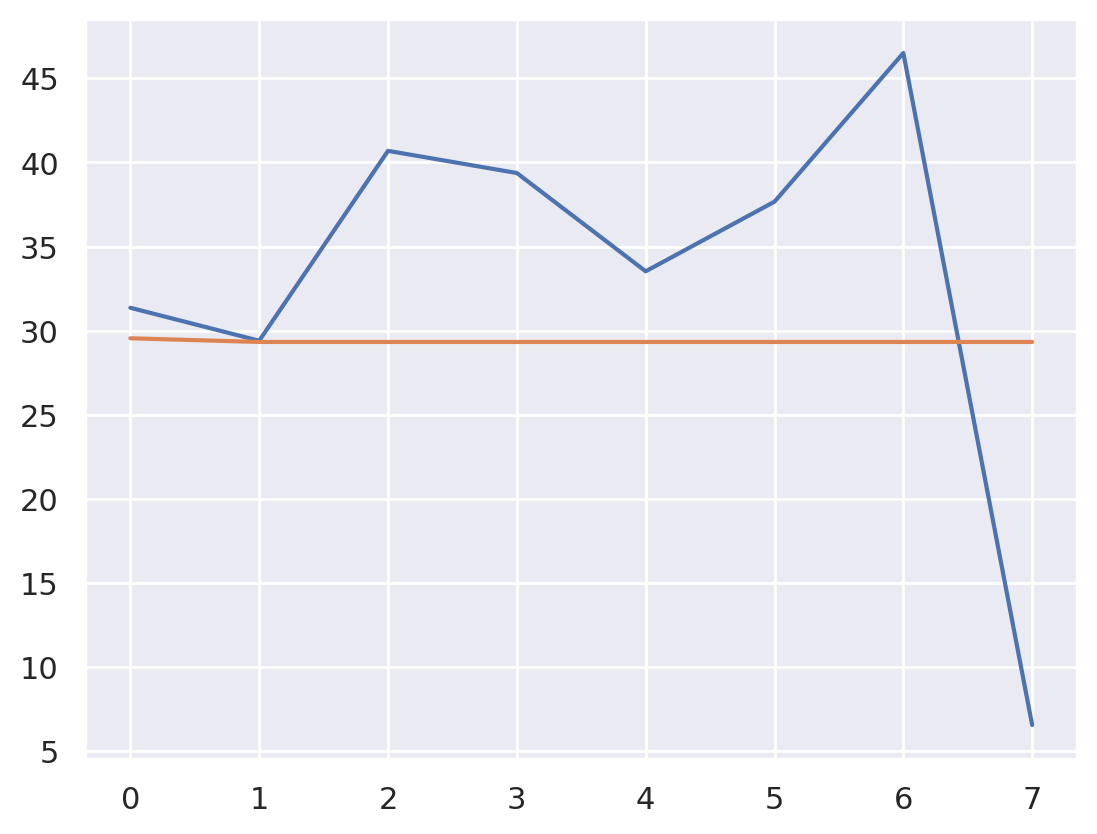

In [183]:
plt.plot(gt)
plt.plot(pd)

In [176]:
snapshot.edge_index

tensor([[  8,  96,  89,  ...,  72, 181, 161],
        [  2, 118,  47,  ...,  47,  31, 149]], device='cuda:2')

In [177]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(snapshot.x.detach().cpu())

NameError: name 'KMeans' is not defined

In [198]:
labels = kmeans.labels_

In [199]:
x = snapshot.x[:, :-1]

In [200]:
new_G = nx.Graph()

In [201]:
snapshot.x.size()

torch.Size([4523, 3])

In [202]:
labels_list = labels.tolist()
for i in range(2326):
    new_G.add_node(i, pos=(x[i][0], x[i][1]), cluster=labels_list[i])

In [203]:
sns.reset_orig()

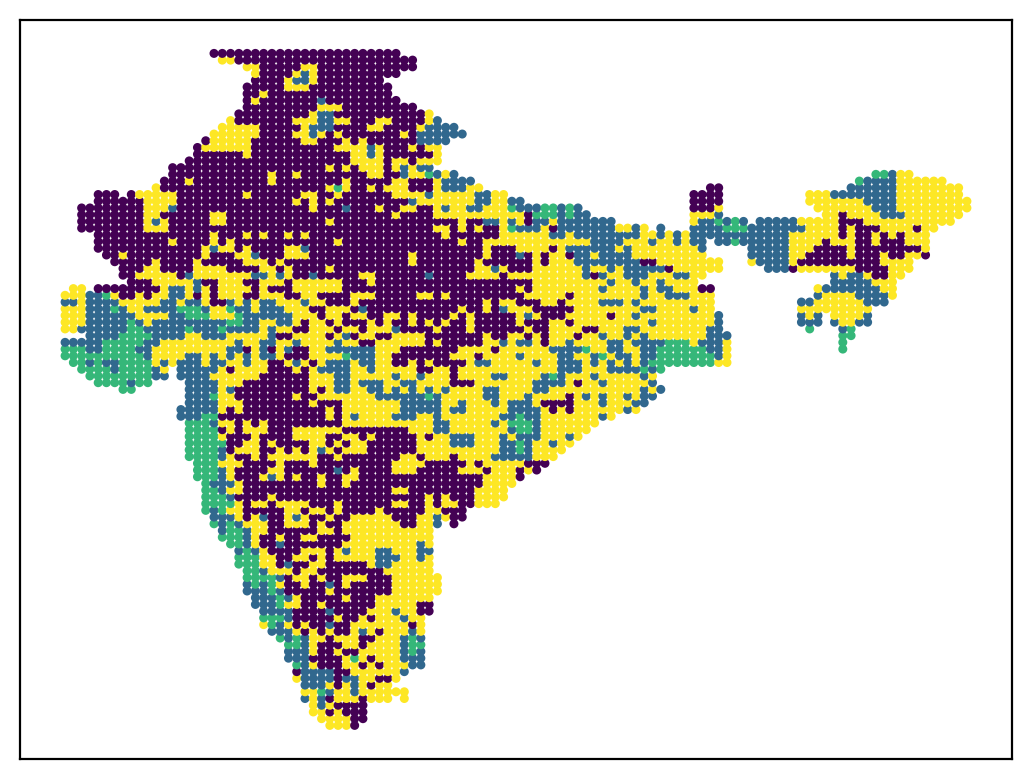

In [208]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=5, node_color=labels_list)
# nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.figsize = (100,100)
# Show the plot
plt.show()

In [145]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.cluster import KMeans

# Define the model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

model = GCN(snapshot.num_node_features, 16, 8)
model = model.to(device)

# Define the loss function
def kmeans_loss(embeddings):
    kmeans = KMeans(n_clusters=8)
    kmeans.fit(embeddings.detach().cpu().numpy())
    labels = torch.tensor(kmeans.labels_).to(device)
    return labels

# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(100):
    optimizer.zero_grad()
    snapshot = snapshot.to(device)
    x = snapshot.x
    edge_index = snapshot.edge_index
    embeddings = model(x, edge_index)
    labels = kmeans_loss(embeddings)
    print(embeddings.shape, "\n---0--\n", labels.shape)
    # loss = F.mse_loss(embeddings, labels)
    # loss.backward()
    optimizer.step()

# Cluster the nodes
x, edge_index = snapshot[0]
embeddings = model(x, edge_index)
labels = kmeans_loss(embeddings)

/home/udit/anaconda3/envs/geometric/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



torch.Size([2326, 8]) 
---0--
 torch.Size([2326])


/home/udit/anaconda3/envs/geometric/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



torch.Size([2326, 8]) 
---0--
 torch.Size([2326])


/home/udit/anaconda3/envs/geometric/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



torch.Size([2326, 8]) 
---0--
 torch.Size([2326])


/home/udit/anaconda3/envs/geometric/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



torch.Size([2326, 8]) 
---0--
 torch.Size([2326])


/home/udit/anaconda3/envs/geometric/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KeyboardInterrupt: 

In [122]:
len(pd)

9

/home/udit/anaconda3/envs/geometric/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning:

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

/home/udit/anaconda3/envs/geometric/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



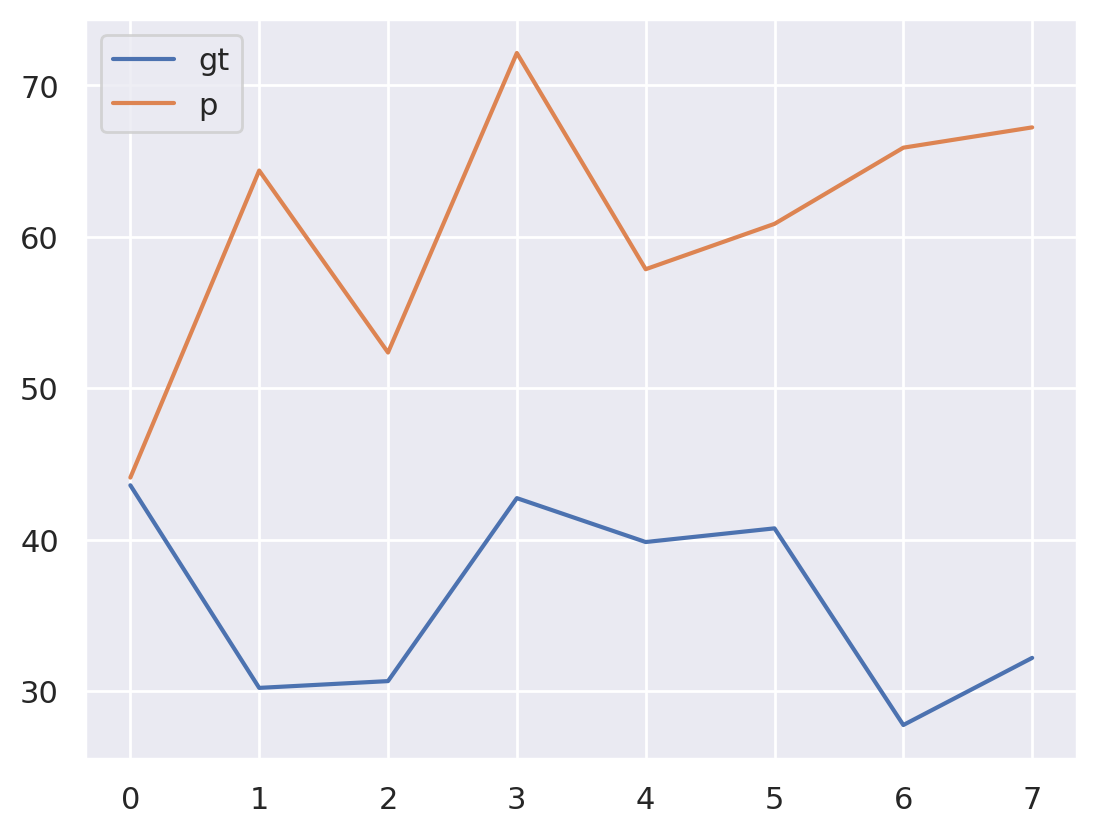

In [123]:
plt.plot(gt[:], label = "gt")
plt.plot(pd[1:], label = "p")
plt.legend()

In [124]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import init_notebook_mode, iplot

# Create two numpy arrays with some sample data
x = np.linspace(0, 5000, 4868)
y1 = (snapshot.y.detach().cpu().reshape(-1,))
y2 = (y_pred.detach().cpu().reshape(-1,))

# Create the traces for each line
trace1 = go.Scatter(x=x, y=y1, mode='lines', name='Sine')
trace2 = go.Scatter(x=x, y=y2, mode='lines', name='Cosine')

# Create the layout for the plot
layout = go.Layout(title='Sine and Cosine Plot')

# Create the figure object and add the traces and layout
fig = go.Figure(data=[trace1, trace2], layout=layout)

iplot(fig)

# Show the plot



NetworkXError: Node 1701 has no position.

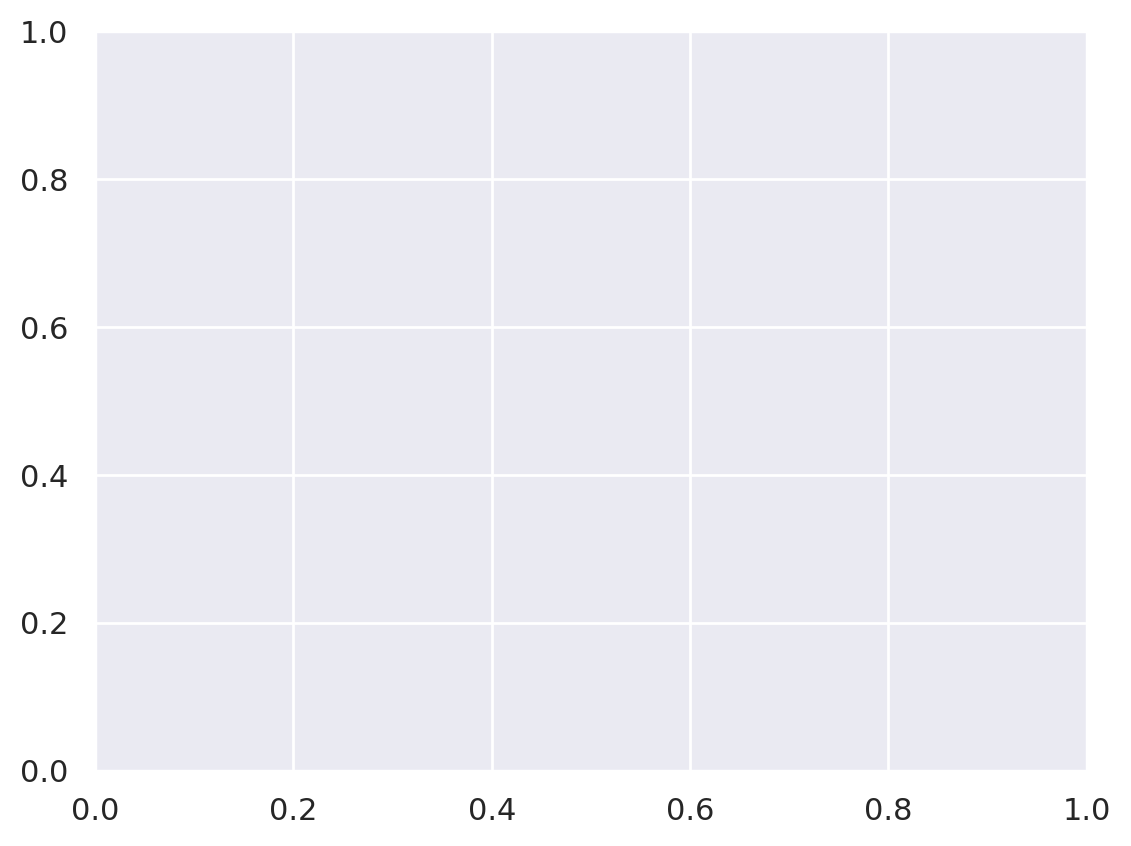

In [44]:
nx.draw_networkx(G, central_pos, node_size = snapshot.y)

0
1
2
3
4
5
6
7


In [40]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

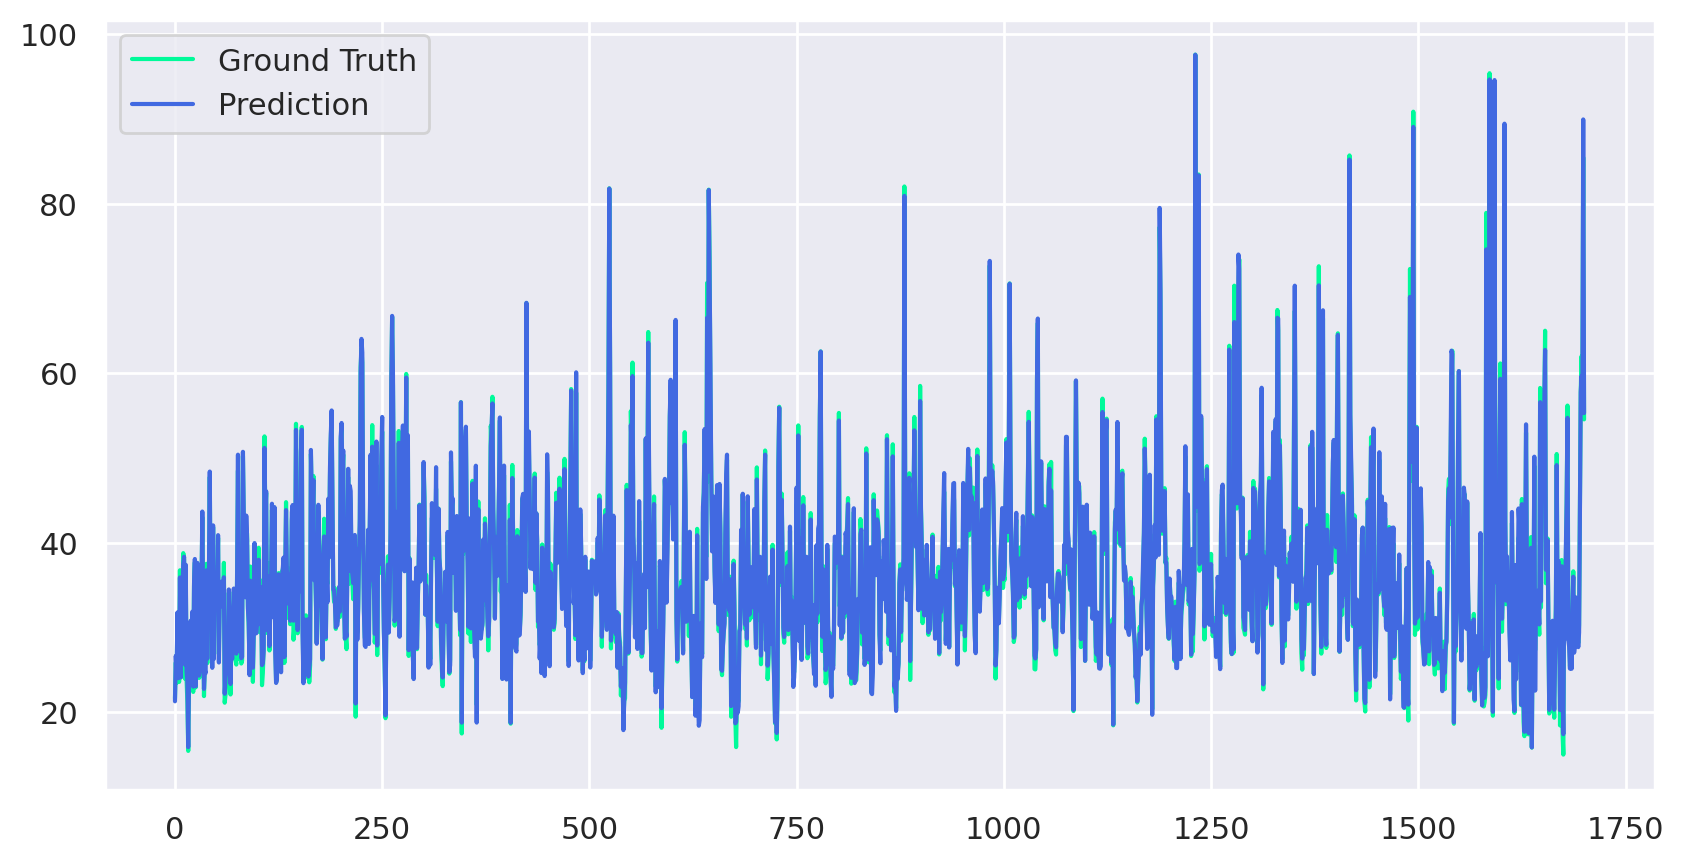

In [175]:
plt.figure(figsize=(10, 5))
# plt.plot((snapshot.x.t()[2].detach().cpu().reshape(-1,1))[:4500, :], label = "Ground Truth", color = "red")

plt.plot(scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1))[:4500, :], label = "Ground Truth", color = "mediumspringgreen")
plt.plot(scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))[:4500, :], label = "Prediction", color = "royalblue")
# plt.plot((snapshot.x.t()[2].detach().cpu().reshape(-1,1))[:4500, :], label = "Ground Truth", color = "red")

plt.legend()

In [242]:
snapshot.x

tensor([[77.0000,  8.2500, 36.4173],
        [77.2500,  8.2500, 44.7962],
        [77.5000,  8.2500, 68.9805],
        ...,
        [74.7500, 37.2500, 18.2979],
        [75.0000, 37.2500, 22.0741],
        [75.2500, 37.2500, 25.3328]], device='cuda:0')

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1)), scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1)))**0.5

19.25259982166782

In [46]:
snapshot.x.t()[1].min()

tensor(8.2500, device='cuda:0')